# retrain rf model

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from joblib import dump, load

ITEMS_NAME=["COAL", "COBBLESTONE", "CRAFTING_TABLE", "DIRT", "FURNACE", "IRON_AXE", "IRON_INGOT", "IRON_ORE", "IRON_PICKAXE", \
          "LOG", "PLANKS", "STICK", "STONE", "STONE_AXE", "STONE_PICKAXE", "TORCH", "WOODEN_AXE", "WOODEN_PICKAXE"] 

FEATURES_NAME=["inventory_firstGainOrder", "inventory_firstGainStep",\
            "inventory_accum_reward", "inventory_rewardedGainStep", "inventory_rewardedGainOrder",\
                     "if_iron_axe", "if_stone_axe", "if_wooden_axe", "sparse_reward", "dense_reward", \
            "attack_effi", "attack_ratio", "attack_equipped", "camera_mov_ratio", "position_mov_ratio", \
            "torch_placed", "cobblestone_placed", "dirt_placed", "stone_placed", "if_smelt_coal"]

def generate_0to5_names():
    names = []
    for i in range(5):
        for j in range(18):
            names.append(FEATURES_NAME[i]+"_"+str(j))
    return names

FEATURES_NAME_0to5=generate_0to5_names()

In [2]:
df = pd.read_csv("./test-data/fea_m_all.csv")
df.attack_effi[df.attack_effi>0.05] = 0.05

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(y_true, y_pred, average=None, labels=['pig', 'dog', 'cat'])

def prepare_Xy(df, test_size = 0.3):
    X=[]
    for fea in FEATURES_NAME:
        X.append(df[fea])
    X.append(df["ai_eva"])
    X.append(df["p1"])
    X.append(df["p2"])
    X.append(df["p3"])
    X=np.array(X).T
    y=np.array(df["m_eva"])
    
    X, y = sklearn.utils.shuffle(X, y) 
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = test_size, random_state = 0)
    return X_train, X_test, y_train, y_test


def k_fold(X_train, y_train, k=4, n=10, max_depth=10, n_estimators=10, min_samples_leaf=2, max_features="log2", store_model=False, print_res=False):
    kf = KFold(n_splits=k, shuffle=True, random_state=204)
    clf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=1, n_estimators=n_estimators)
    
    sampled_accs=[]
    sampled_preds=[]
    sampled_conf_mats=[]
    
    accs=[]
    train_accs=[]
    preds=[]
    gts=[]
    conf_mats=[]
    classes=[1,2,3]
    for i in range(n):
#         print("No : {}".format(i))
        for train, dev in kf.split(X_train, y_train):
            clf.fit(X_train[train], y_train[train])
            
            y_true=y_train[dev].tolist()
            gts.append(y_true)
            
            proba = clf.predict_proba(X_train[dev])
            y_pred=clf.predict(X_train[dev]).tolist()
            sampled_pred = [np.random.choice(len(p), p=p)+1 for p in proba]
            for i in range(len(sampled_pred)):
                if y_pred[i]==1:
                    sampled_pred[i]=1
            sampled_preds.append(sampled_pred)
            sampled_conf_mat = confusion_matrix(y_true, sampled_pred)
            sampled_conf_mats.append(sampled_conf_mat)
            
            y_pred=clf.predict(X_train[dev]).tolist()
            preds.append(y_pred)
            conf_mat = confusion_matrix(y_true, y_pred)
            conf_mats.append(conf_mat)
            
            acc = clf.score(X_train[dev], y_train[dev])
            accs.append(acc)
            sampled_accs.append(accuracy_score(y_true, sampled_pred))
            
            train_acc=clf.score(X_train[train], y_train[train])
            train_accs.append(train_acc)
#             print("gts:", gts, "preds:",preds)
#             print("acc : {}".format(acc))
#             print("feature_importances : {}".format(clf.feature_importances_)) 
            
    sampled_accs=np.array(sampled_accs)
    sampled_acc_ave=np.mean(sampled_accs)
    sampled_acc_std=np.std(sampled_accs)
    
    accs=np.array(accs)
    acc_ave=np.mean(accs)
    acc_std=np.std(accs)

    train_accs=np.array(train_accs)
    train_acc_ave=np.mean(train_accs)
    train_acc_std=np.std(train_accs)
    
    gts_array=np.array(sum(gts,[])) 
    preds_array=np.array(sum(preds,[]))
    sampled_preds_array=np.array(sum(sampled_preds,[]))
   
    sampled_confusion_mat = confusion_matrix(gts_array, sampled_preds_array)
    confusion_mat = confusion_matrix(gts_array, preds_array)

    clf.fit(X_train, y_train)
    final_Acc=clf.score(X_train, y_train)
    
    if print_res:
        print("\ntest_acc_ave : {}, test_acc_std:{}".format(acc_ave, acc_std))
        print("\ntrain_acc_ave : {}, train_acc_std:{}".format(train_acc_ave, train_acc_std))
        print("final_Acc:", final_Acc)

        print(gts_array.shape, preds_array.shape)
        print("gts:", gts_array, "preds:",preds_array)
        print("confusion_mat : {}".format(confusion_mat))
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
        disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal", values_format="d")
        plt.show()

    if store_model:
        dump(clf, 'RF-2.model')
    
    #return acc_ave, acc_std, clf, train_acc_ave, train_acc_std, final_Acc, confusion_mat
    return sampled_acc_ave, sampled_acc_std, clf, train_acc_ave, train_acc_std, final_Acc, sampled_confusion_mat, \
        gts_array, sampled_preds_array
        
    
def final_test(clf, X_test, y_test):
    classes=[1,2,3]
    acc = clf.score(X_test, y_test)
    print("acc : {}".format(acc))
    print("feature_importances : {}".format(clf.feature_importances_)) 
    
    confusion_mat = confusion_matrix(y_test, clf.predict(X_test))
    print("confusion_mat : {}".format(confusion_mat))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal", values_format="d")
    plt.show()
    
    return acc


In [24]:
def repeat_test(n=10, max_depth=5, n_estimators=10, min_samples_leaf=4):
    X_train, X_test, y_train, y_test=prepare_Xy(df)
    X=np.concatenate((X_train, X_test))
    y=np.concatenate((y_train, y_test))
    acc_aves=[]
    acc_stds=[]
    train_acc_aves=[]
    train_acc_stds=[]
    final_Accs=[]
    confusion_mats=[]
    y_truths=[]
    y_preds=[]
    
    for i in range(n): 
        if i%10==9:
            print("No : {}".format(i))
        acc_ave, acc_std, clf, train_acc_ave, train_acc_std, final_Acc, confusion_mat, gts, preds=k_fold(X, y, k=10, n=1, 
                             max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf) 
        y_truths.append(gts)
        y_preds.append(preds)
        acc_aves.append(acc_ave)
        acc_stds.append(acc_std)
        train_acc_aves.append(train_acc_ave)
        train_acc_stds.append(train_acc_std)
        final_Accs.append(final_Acc)
        confusion_mats.append(confusion_mat)
        
        X, y = sklearn.utils.shuffle(X, y) 
    acc_aves=np.array(acc_aves)
    acc_stds=np.array(acc_stds)
    train_acc_aves=np.array(train_acc_aves)
    train_acc_stds=np.array(train_acc_stds)
    final_Accs=np.array(final_Accs)
    confusion_mats=np.array(confusion_mats)
    print("\nacc_aves_ave : {:.4}, acc_aves_std : {:.4}, acc_stds_ave:{:.4}"
          .format(np.mean(acc_aves),np.std(acc_aves), np.mean(acc_stds)))
    print("train_acc_aves_ave : {:.4}, train_acc_aves_std : {:.4}, train_acc_stds_ave:{:.4}"
          .format(np.mean(train_acc_aves),np.std(train_acc_aves), np.mean(train_acc_stds)))
    print("final_Accs_ave : {:.4}, final_Accs_std : {:.4}"
          .format(np.mean(final_Accs),np.std(final_Accs)))
    confusion_mats_sum=np.sum(confusion_mats,axis=0)
    print(confusion_mats_sum)
    classes=[1,2,3]
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mats_sum, display_labels=classes)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal", values_format="d")
    plt.show()
    
    return confusion_mats, y_truths, y_preds
    

In [34]:
def print_metrics(y_truths, y_preds):
    y_truths=np.array(y_truths).flatten()
    y_preds=np.array(y_preds).flatten()
    (precision,recall,f1,support)=precision_recall_fscore_support(y_truths, y_preds, average=None, labels=[1, 2, 3])
    print("labels=[1, 2, 3]")
    print("precision", precision)
    print("recall", recall)
    print("f1", f1)
    print("support", support)
    macro=precision_recall_fscore_support(y_truths, y_preds, average='macro')
    micro=precision_recall_fscore_support(y_truths, y_preds, average='micro')
    weighted=precision_recall_fscore_support(y_truths, y_preds, average='weighted')
    print("precision, recall, f1:")
    print("macro",macro)
    print("micro",micro)
    print("weighted",weighted)

### Sampled

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.4275, acc_aves_std : 0.05084, acc_stds_ave:0.1556
train_acc_aves_ave : 0.8395, train_acc_aves_std : 0.008714, train_acc_stds_ave:0.02401
final_Accs_ave : 0.8315, final_Accs_std : 0.02127
[[133 301 216]
 [307 881 712]
 [234 721 845]]


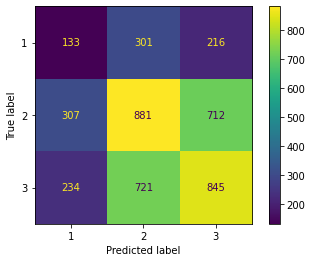

In [26]:
#sampled-2
confusion_mats, y_truths, y_preds=repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

In [35]:
print_metrics(y_truths, y_preds)

labels=[1, 2, 3]
precision [0.19732938 0.46295323 0.47659334]
recall [0.20461538 0.46368421 0.46944444]
f1 [0.20090634 0.46331843 0.47299188]
support [ 650 1900 1800]
precision, recall, f1:
macro (0.3789586510692025, 0.37924801319538165, 0.37907222026610093, None)
micro (0.42735632183908046, 0.42735632183908046, 0.4273563218390805, None)
weighted (0.42890649553214716, 0.42735632183908046, 0.42811023830943834, None)


In [22]:
marg_truths=np.sum(confusion_mats, axis=2) #marg_truths #[13, 38, 36] *50
marg_preds=np.sum(confusion_mats, axis=1)

print("truths",np.sum(marg_truths, axis=0))
print("preds",np.sum(marg_preds, axis=0))

truths [ 650 1900 1800]
preds [ 651 1904 1795]


No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.4348, acc_aves_std : 0.05438, acc_stds_ave:0.1621
train_acc_aves_ave : 0.8406, train_acc_aves_std : 0.008463, train_acc_stds_ave:0.02487
final_Accs_ave : 0.8421, final_Accs_std : 0.02002
[[129 307 214]
 [281 910 709]
 [235 714 851]]


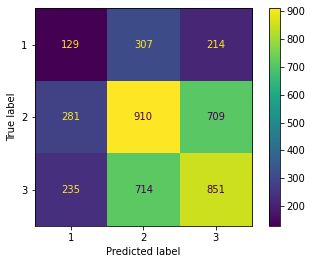

ValueError: multiclass-multioutput is not supported

In [14]:
#sampled-1
confusion_mats=repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

In [15]:
confusion_mats

array([[[ 2,  4,  7],
        [ 6, 16, 16],
        [ 3, 16, 17]],

       [[ 2,  6,  5],
        [ 4, 19, 15],
        [ 5, 13, 18]],

       [[ 0, 10,  3],
        [ 8, 18, 12],
        [ 4, 22, 10]],

       [[ 4,  5,  4],
        [ 2, 19, 17],
        [ 5, 16, 15]],

       [[ 1,  5,  7],
        [ 4, 21, 13],
        [ 9, 11, 16]],

       [[ 3,  6,  4],
        [ 3, 21, 14],
        [ 6, 12, 18]],

       [[ 0, 10,  3],
        [ 5, 13, 20],
        [ 4, 18, 14]],

       [[ 5,  3,  5],
        [ 8, 16, 14],
        [ 4, 14, 18]],

       [[ 1,  6,  6],
        [ 3, 19, 16],
        [ 3, 16, 17]],

       [[ 4,  5,  4],
        [11, 16, 11],
        [ 5, 13, 18]],

       [[ 4,  6,  3],
        [ 6, 14, 18],
        [ 4, 13, 19]],

       [[ 1,  4,  8],
        [ 6, 17, 15],
        [ 5, 17, 14]],

       [[ 3,  7,  3],
        [ 5, 19, 14],
        [ 1, 19, 16]],

       [[ 3,  9,  1],
        [ 2, 21, 15],
        [ 5, 15, 16]],

       [[ 3,  5,  5],
        [ 8, 22,  8],
    

In [16]:
marg_truths=np.sum(confusion_mats, axis=2) #marg_truths #[13, 38, 36] *50
marg_preds=np.sum(confusion_mats, axis=1)

print("truths",np.sum(marg_truths, axis=0))
print("preds",np.sum(marg_preds, axis=0))

truths [ 650 1900 1800]
preds [ 651 1904 1795]


In [17]:
np.mean(marg_preds, axis=0)

array([13.02, 38.08, 35.9 ])

In [18]:
np.std(marg_preds, axis=0)

array([3.30145423, 4.20875278, 4.05092582])

In [19]:
marg_preds

array([[11, 36, 40],
       [11, 38, 38],
       [12, 50, 25],
       [11, 40, 36],
       [14, 37, 36],
       [12, 39, 36],
       [ 9, 41, 37],
       [17, 33, 37],
       [ 7, 41, 39],
       [20, 34, 33],
       [14, 33, 40],
       [12, 38, 37],
       [ 9, 45, 33],
       [10, 45, 32],
       [14, 42, 31],
       [18, 37, 32],
       [14, 42, 31],
       [11, 39, 37],
       [12, 44, 31],
       [23, 32, 32],
       [13, 35, 39],
       [10, 32, 45],
       [16, 40, 31],
       [11, 39, 37],
       [17, 35, 35],
       [16, 38, 33],
       [12, 37, 38],
       [18, 42, 27],
       [13, 39, 35],
       [11, 31, 45],
       [14, 43, 30],
       [12, 34, 41],
       [10, 36, 41],
       [15, 37, 35],
       [ 7, 48, 32],
       [ 6, 42, 39],
       [12, 39, 36],
       [14, 39, 34],
       [11, 40, 36],
       [11, 37, 39],
       [13, 33, 41],
       [14, 33, 40],
       [13, 37, 37],
       [16, 32, 39],
       [17, 36, 34],
       [19, 34, 34],
       [11, 40, 36],
       [13, 3

### non-sampled

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5535, acc_aves_std : 0.02362, acc_stds_ave:0.154
train_acc_aves_ave : 0.8413, train_acc_aves_std : 0.01005, train_acc_stds_ave:0.02527
final_Accs_ave : 0.8414, final_Accs_std : 0.02181
[[  31  415  204]
 [  25 1223  652]
 [   9  638 1153]]


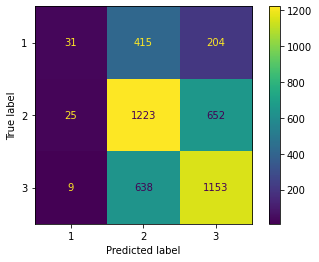

In [57]:
#non-sampled
confusion_mats=repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

In [58]:
#non-sampled
confusion_mats

array([[[ 2,  6,  5],
        [ 0, 24, 14],
        [ 0, 12, 24]],

       [[ 2,  7,  4],
        [ 0, 26, 12],
        [ 0, 11, 25]],

       [[ 0,  8,  5],
        [ 1, 23, 14],
        [ 0, 11, 25]],

       [[ 1,  7,  5],
        [ 1, 24, 13],
        [ 0, 11, 25]],

       [[ 1,  7,  5],
        [ 1, 23, 14],
        [ 0, 10, 26]],

       [[ 0,  9,  4],
        [ 2, 23, 13],
        [ 0, 14, 22]],

       [[ 0,  9,  4],
        [ 0, 24, 14],
        [ 0, 11, 25]],

       [[ 0,  9,  4],
        [ 0, 24, 14],
        [ 0, 14, 22]],

       [[ 1,  8,  4],
        [ 1, 22, 15],
        [ 1, 11, 24]],

       [[ 0,  9,  4],
        [ 0, 24, 14],
        [ 0, 12, 24]],

       [[ 1,  8,  4],
        [ 0, 22, 16],
        [ 0, 13, 23]],

       [[ 0,  9,  4],
        [ 2, 23, 13],
        [ 1, 10, 25]],

       [[ 1, 10,  2],
        [ 1, 26, 11],
        [ 0, 15, 21]],

       [[ 0,  8,  5],
        [ 0, 23, 15],
        [ 0, 11, 25]],

       [[ 1,  9,  3],
        [ 1, 26, 11],
    

In [60]:
#non-sampled
marg_truths=np.sum(confusion_mats, axis=2) #marg_truths #[13, 38, 36] *50
marg_preds=np.sum(confusion_mats, axis=1)

print("truths",np.sum(marg_truths, axis=0))
print("preds",np.sum(marg_preds, axis=0))

truths [ 650 1900 1800]
preds [  65 2276 2009]


In [64]:
#non-sampled
np.std(marg_preds, axis=0)

array([0.9       , 3.16379519, 3.06391906])

In [65]:
#non-sampled
np.mean(marg_preds, axis=0)

array([ 1.3 , 45.52, 40.18])

In [63]:
#non-sampled
marg_preds

array([[ 2, 42, 43],
       [ 2, 44, 41],
       [ 1, 42, 44],
       [ 2, 42, 43],
       [ 2, 40, 45],
       [ 2, 46, 39],
       [ 0, 44, 43],
       [ 0, 47, 40],
       [ 3, 41, 43],
       [ 0, 45, 42],
       [ 1, 43, 43],
       [ 3, 42, 42],
       [ 2, 51, 34],
       [ 0, 42, 45],
       [ 2, 47, 38],
       [ 4, 45, 38],
       [ 1, 44, 42],
       [ 1, 50, 36],
       [ 2, 44, 41],
       [ 1, 45, 41],
       [ 2, 48, 37],
       [ 1, 44, 42],
       [ 1, 44, 42],
       [ 1, 46, 40],
       [ 1, 45, 41],
       [ 2, 47, 38],
       [ 0, 51, 36],
       [ 0, 49, 38],
       [ 1, 50, 36],
       [ 2, 47, 38],
       [ 2, 39, 46],
       [ 2, 40, 45],
       [ 0, 52, 35],
       [ 2, 45, 40],
       [ 1, 44, 42],
       [ 2, 46, 39],
       [ 1, 46, 40],
       [ 0, 45, 42],
       [ 0, 42, 45],
       [ 2, 51, 34],
       [ 1, 51, 35],
       [ 1, 46, 40],
       [ 1, 48, 38],
       [ 1, 50, 36],
       [ 1, 46, 40],
       [ 2, 47, 38],
       [ 1, 48, 38],
       [ 2, 4

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5244, acc_aves_std : 0.03727, acc_stds_ave:0.1583
train_acc_aves_ave : 0.8213, train_acc_aves_std : 0.0118, train_acc_stds_ave:0.02745
final_Accs_ave : 0.8191, final_Accs_std : 0.02619
[[  43  419  188]
 [  51 1160  689]
 [  21  701 1078]]


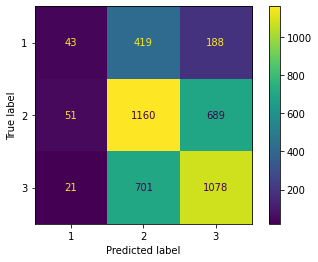

In [27]:
#non-sampled
repeat_test(n=50, max_depth=5, n_estimators=20, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5541, acc_aves_std : 0.02933, acc_stds_ave:0.1596
train_acc_aves_ave : 0.8383, train_acc_aves_std : 0.009231, train_acc_stds_ave:0.0249
final_Accs_ave : 0.832, final_Accs_std : 0.0208
[[  33  401  216]
 [  22 1214  664]
 [  10  627 1163]]


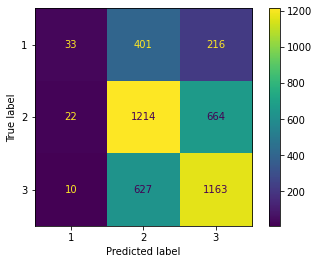

In [33]:
#non-sampled
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5488, acc_aves_std : 0.02837, acc_stds_ave:0.1584
train_acc_aves_ave : 0.8407, train_acc_aves_std : 0.008353, train_acc_stds_ave:0.02424
final_Accs_ave : 0.8395, final_Accs_std : 0.0224
[[  22  426  202]
 [  24 1205  671]
 [   8  634 1158]]


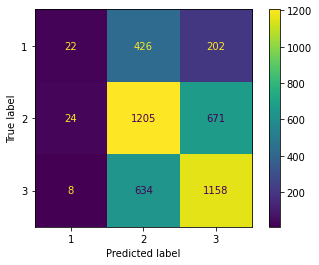

In [46]:
#non-sampled
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5395, acc_aves_std : 0.0254, acc_stds_ave:0.1552
train_acc_aves_ave : 0.7997, train_acc_aves_std : 0.009794, train_acc_stds_ave:0.02797
final_Accs_ave : 0.7972, final_Accs_std : 0.02342
[[  10  430  210]
 [  22 1186  692]
 [   1  650 1149]]


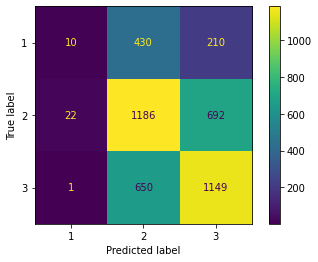

In [34]:
#non-sampled
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=5)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5356, acc_aves_std : 0.02948, acc_stds_ave:0.1567
train_acc_aves_ave : 0.762, train_acc_aves_std : 0.008475, train_acc_stds_ave:0.027
final_Accs_ave : 0.7664, final_Accs_std : 0.02327
[[   2  438  210]
 [  12 1199  689]
 [   1  670 1129]]


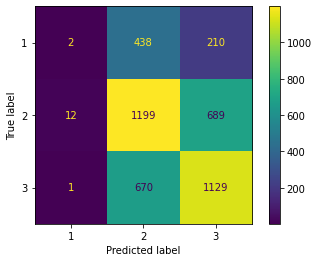

In [35]:
#non-sampled
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=6)

### write to new csv

In [34]:
def predict_rf2(df):
    clf = load('./models/RF-2.model')
    X=[]
    for fea in FEATURES_NAME:
        X.append(df[fea])
    X.append(df["ai_eva"])
    X.append(df["p1"])
    X.append(df["p2"])
    X.append(df["p3"])
    X=np.array(X).T
    y=np.array(df["m_eva"])
    
    prediction = clf.predict(X)
    pred_prob=clf.predict_proba(X)
    
    df.insert(df.shape[1], "ai2_eva", prediction)
    df.insert(df.shape[1], "ai2_p1", pred_prob[:,0])
    df.insert(df.shape[1], "ai2_p2", pred_prob[:,1])
    df.insert(df.shape[1], "ai2_p3", pred_prob[:,2])
    
    df.to_csv("./test-data/fea_m_all_ai2.csv", encoding="utf_8_sig", index=False)
 
    return prediction, pred_prob



In [35]:
prediction, pred_prob=predict_rf2(df)
print(prediction.shape)
print(pred_prob.shape)

(87,)
(87, 3)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  

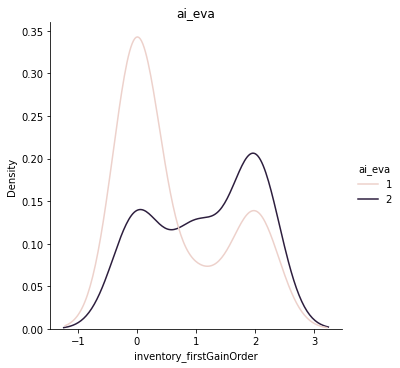

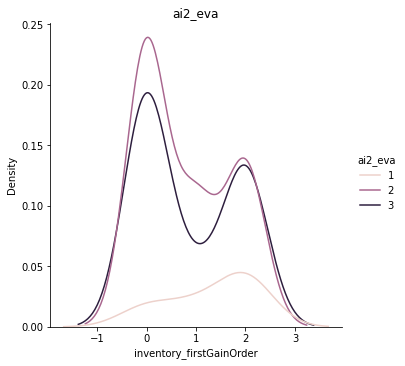

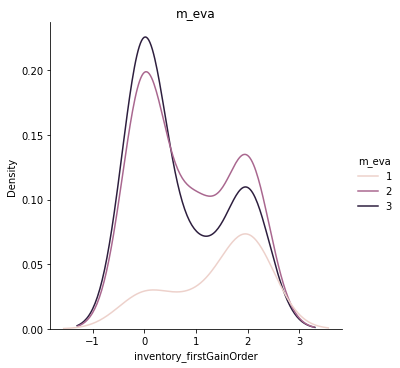

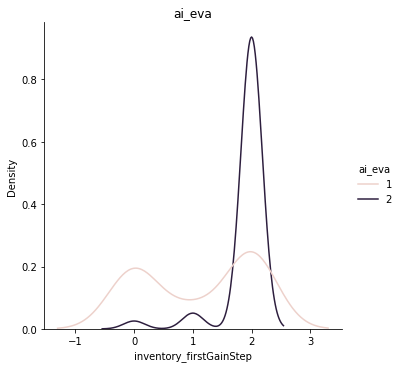

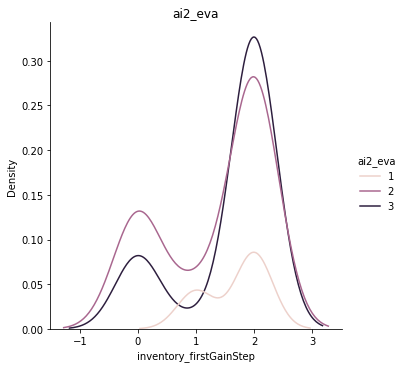

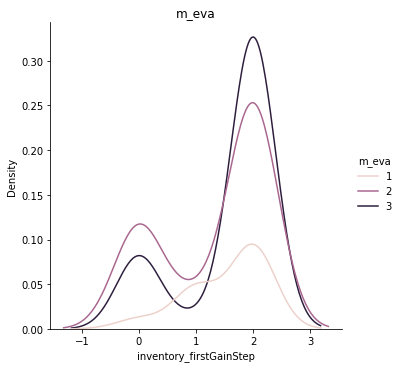

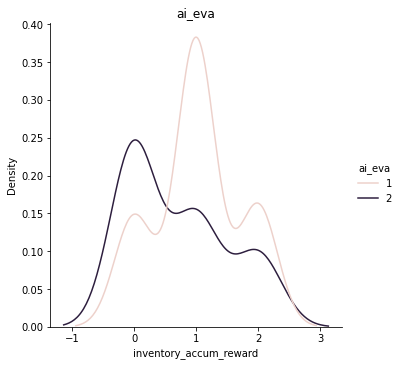

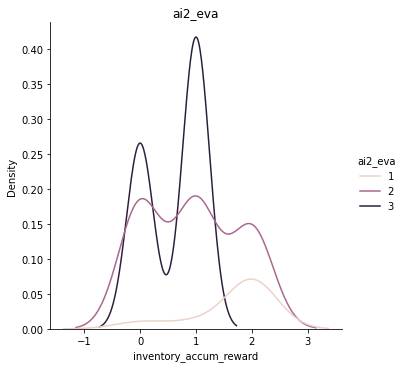

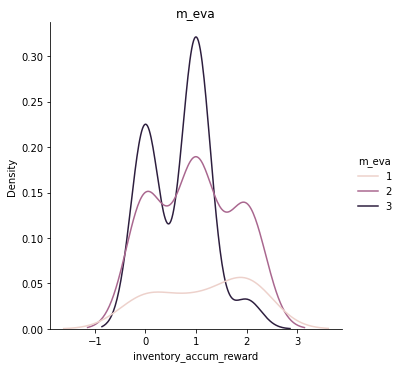

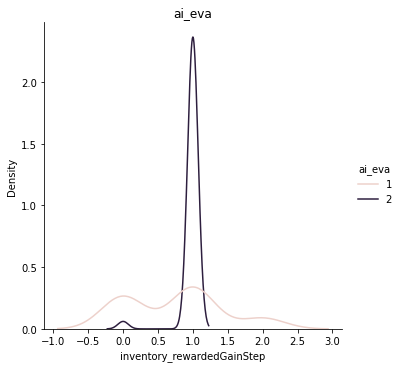

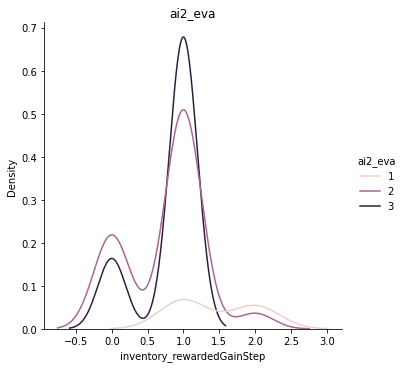

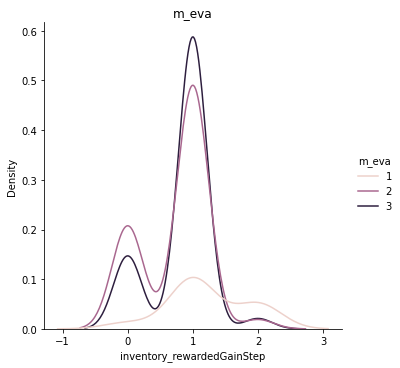

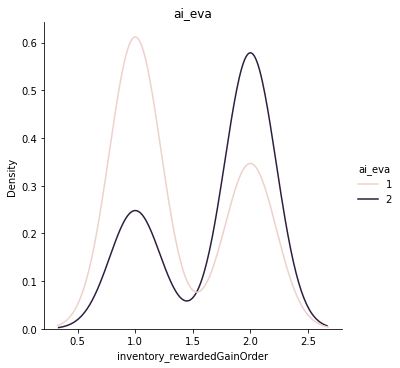

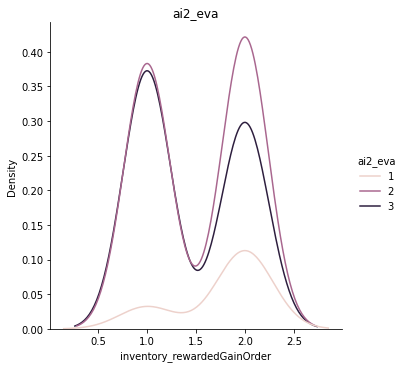

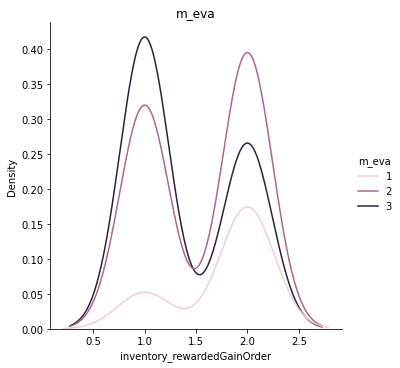

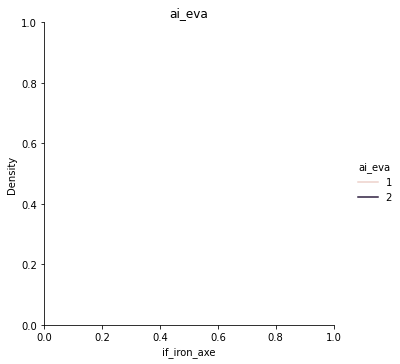

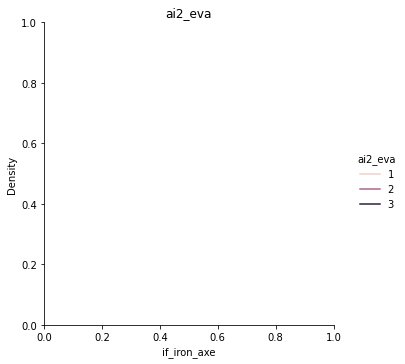

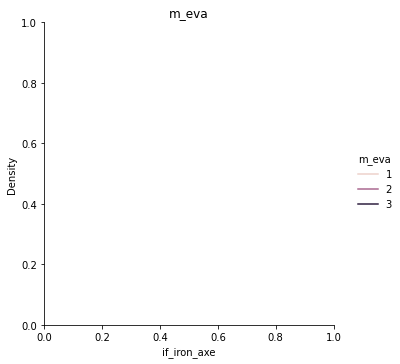

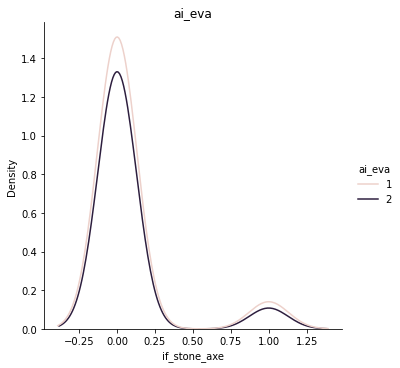

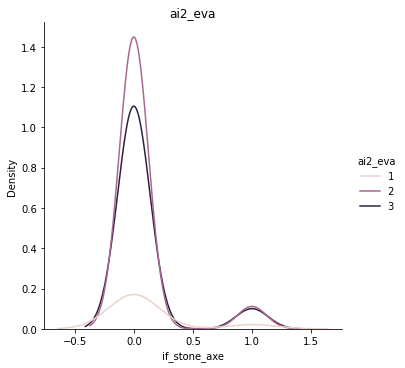

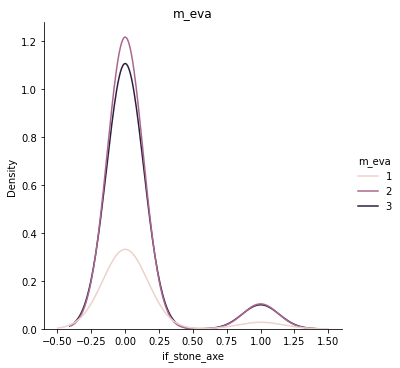

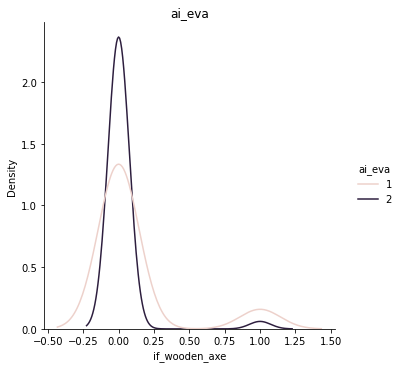

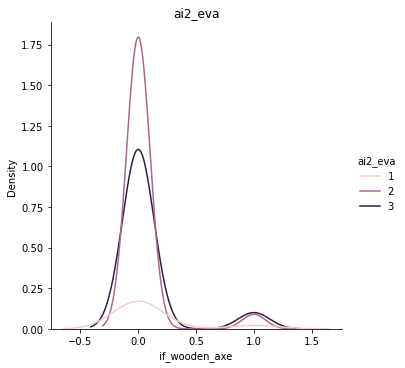

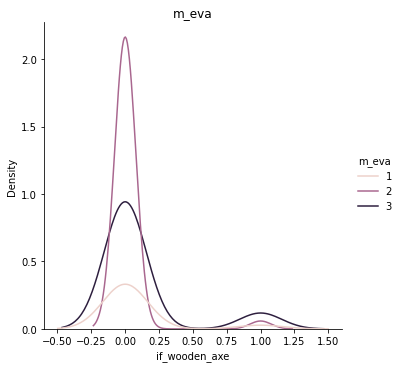

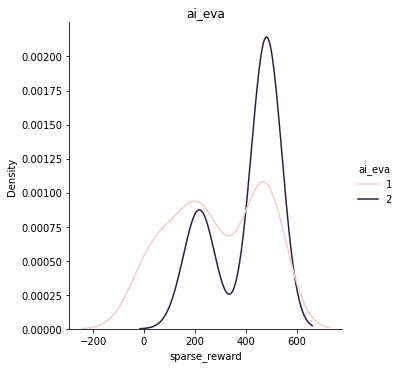

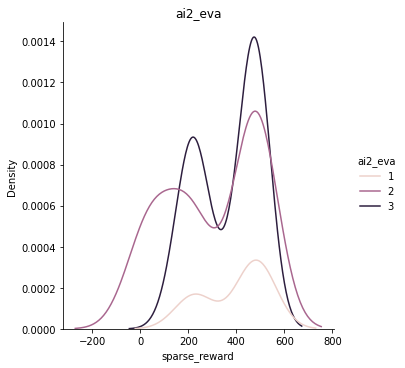

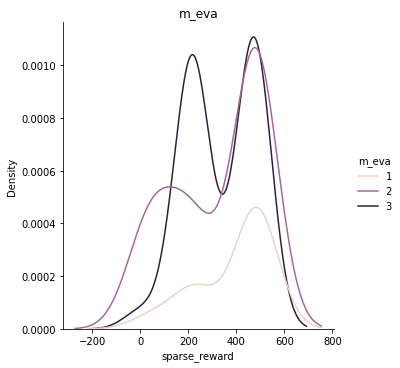

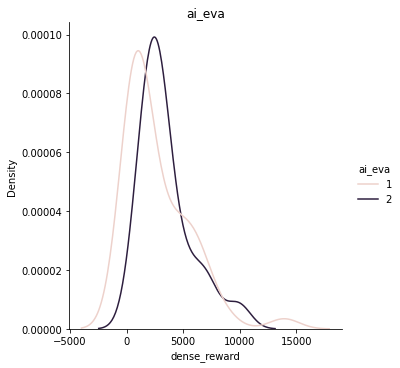

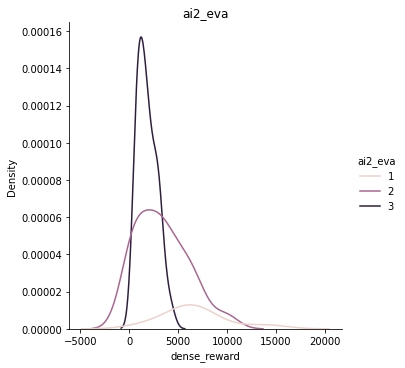

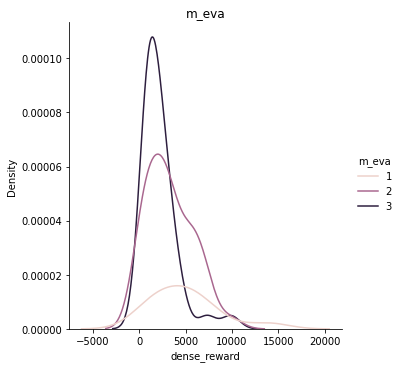

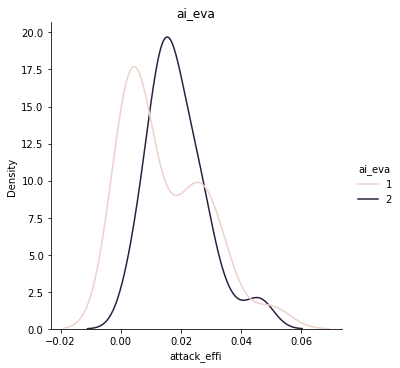

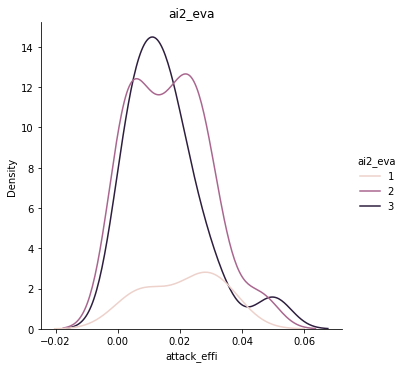

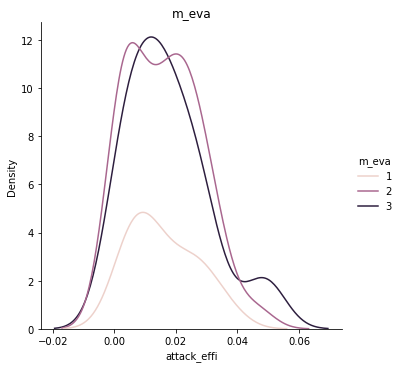

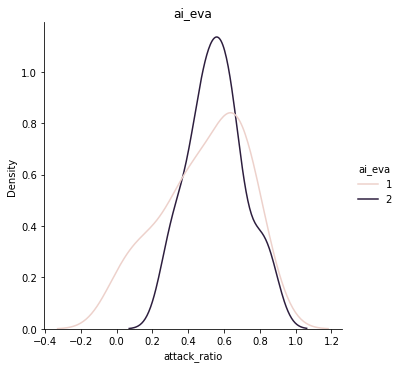

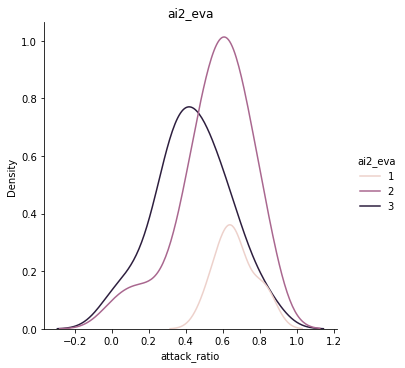

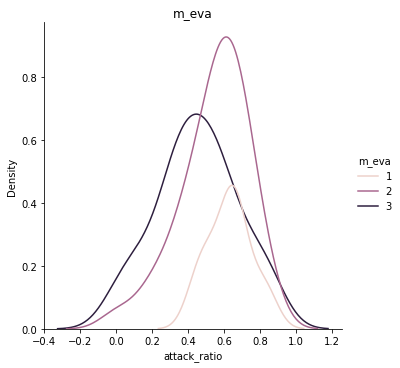

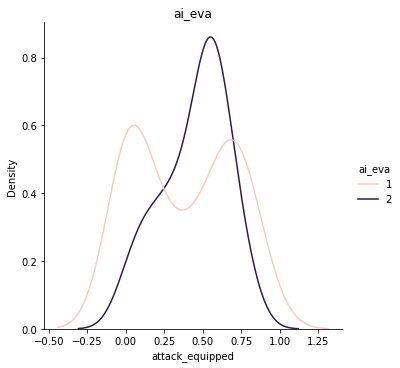

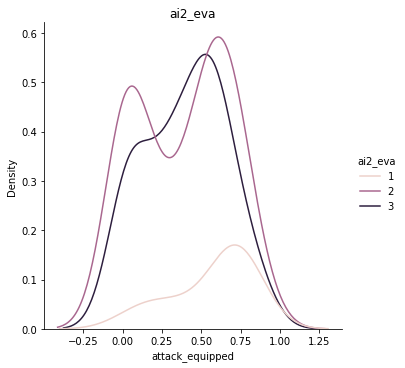

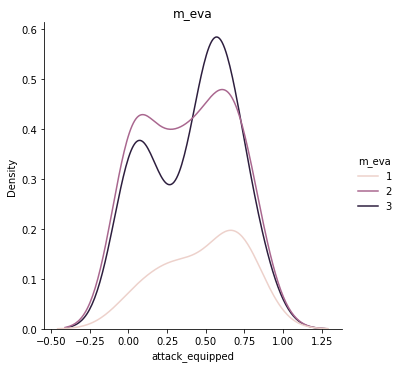

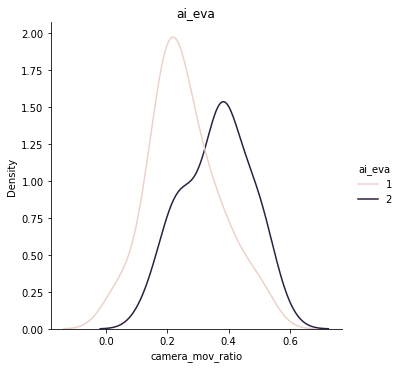

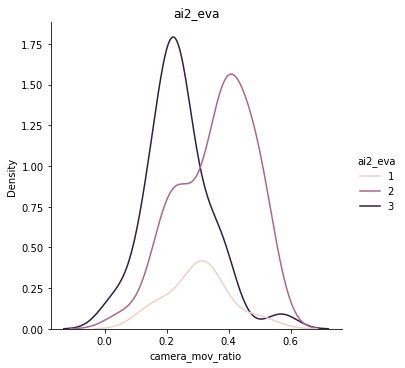

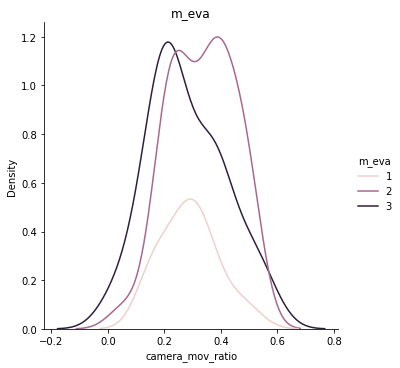

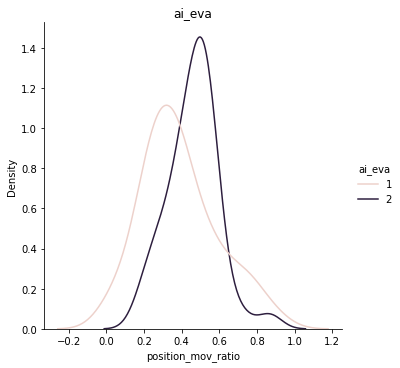

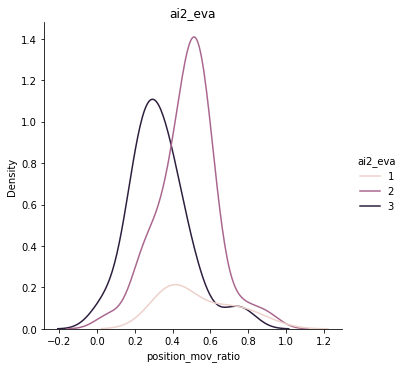

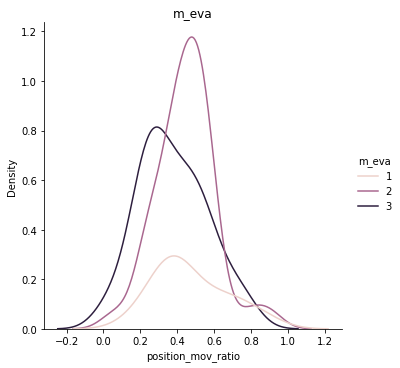

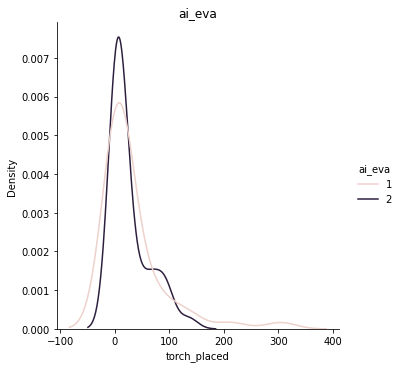

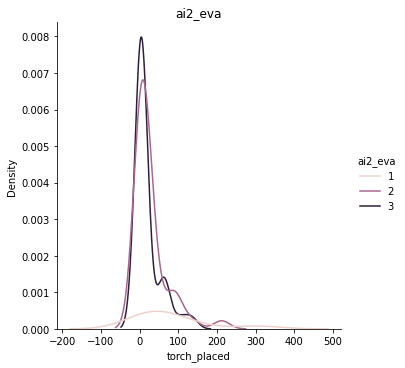

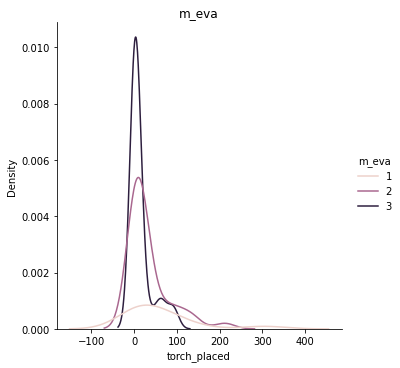

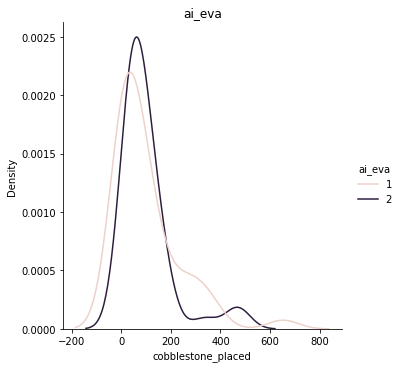

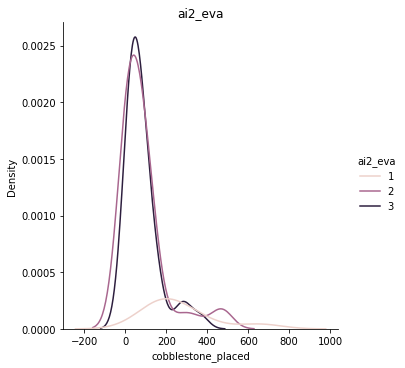

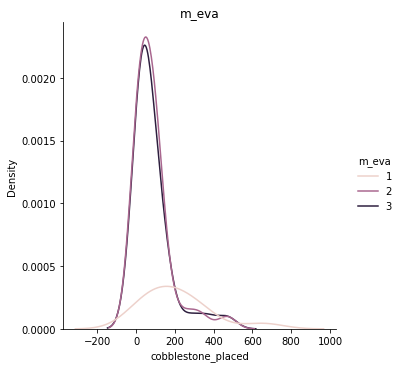

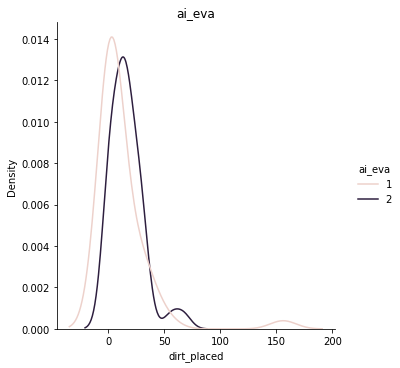

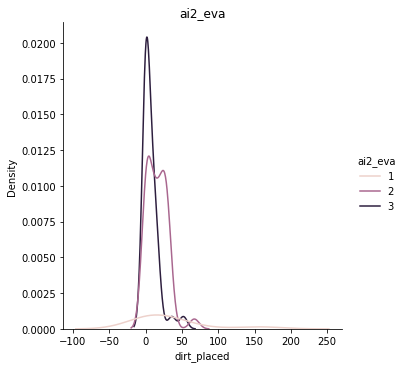

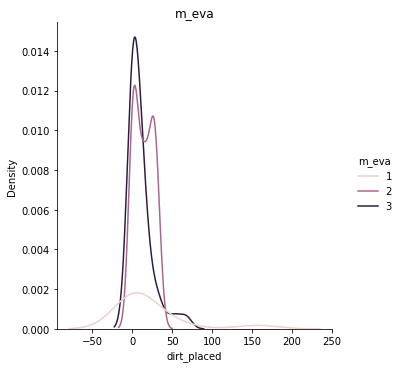

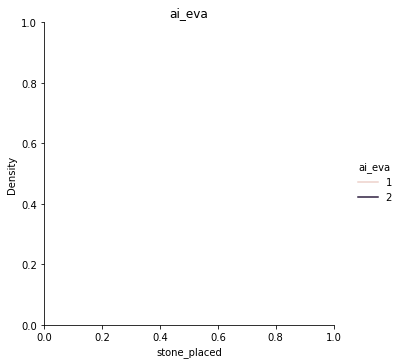

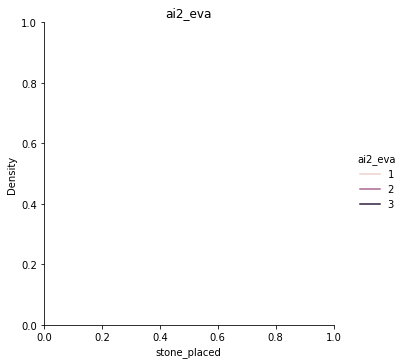

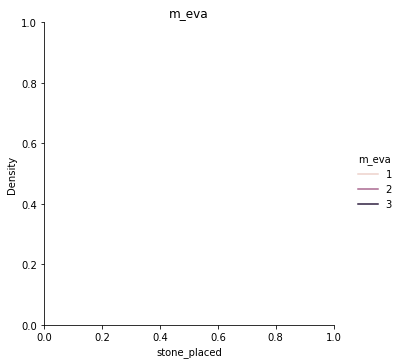

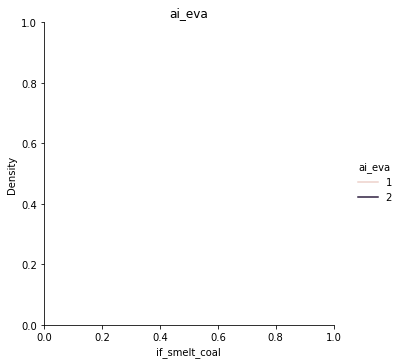

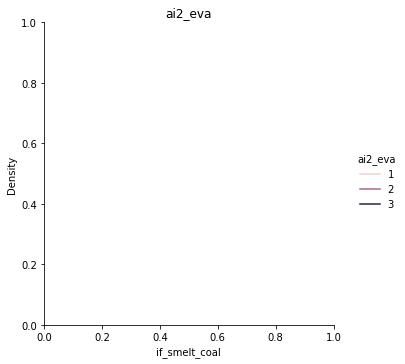

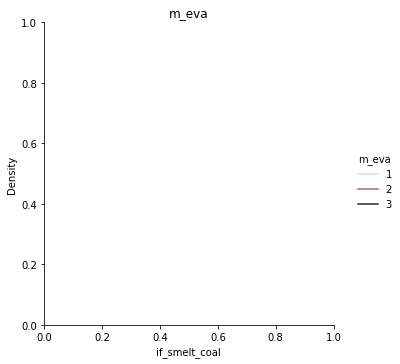

In [52]:
for name in FEATURES_NAME:
    sns.displot(data=df, x=name, hue="ai_eva", kind="kde").set(title='ai_eva')
    sns.displot(data=df, x=name, hue="ai2_eva", kind="kde").set(title='ai2_eva')
    sns.displot(data=df, x=name, hue="m_eva", kind="kde").set(title='m_eva')
#     f=plt.figure()
#     f.add_subplot(1,3,1)
#     sns.displot(data=df, x=name, hue="ai_eva", kind="kde").set(title='ai_eva')
#     f.add_subplot(1,3,2)
#     sns.displot(data=df, x=name, hue="ai2_eva", kind="kde").set(title='ai2_eva')
#     f.add_subplot(1,3,3)
#     sns.displot(data=df, x=name, hue="m_eva", kind="kde").set(title='m_eva')
#     plt.show()
    
    
#     fig, axes = plt.subplots(1, 3)#, figsize=(15, 5), sharey=True
# #     fig.suptitle('Initial Pokemon - 1st Generation')
#     sns.displot(ax=axes[0], data=df, x=name, hue="ai_eva", kind="kde").set(title='ai_eva')
# #     axes[0].set_title(bulbasaur.name)
#     sns.displot(ax=axes[1], data=df, x=name, hue="ai2_eva", kind="kde").set(title='ai2_eva')
#     sns.displot(ax=axes[2], data=df, x=name, hue="m_eva", kind="kde").set(title='m_eva')
    
    

    

In [ ]:
# m_eva=3,ai_eva=1
#31
# m_eva=1,ai_eva=2
#12


# m_eva=3, ai2_eva=1&2
32
# m_eva=1, ai2_eva=3
13

In [59]:
# df.insert(df.shape[1], "m_ai1", df["m_eva"]+df["ai_eva"])
# df.insert(df.shape[1], "m_ai2", df["m_eva"]+df["ai2_eva"])
df["m_ai1"]=df["m_eva"].map(str)+df["ai_eva"].map(str)
df["m_ai2"]=df["m_eva"].map(str)+df["ai2_eva"].map(str)
df.to_csv("./test-data/fea_m_all_ai2.csv", encoding="utf_8_sig", index=False)

In [67]:
df["m_ai1_2"]=df["m_eva"].map(str)+df["ai_eva"].map(str)+df["ai2_eva"].map(str)
df.to_csv("./test-data/fea_m_all_ai2.csv", encoding="utf_8_sig", index=False)